# Chinese Version TFIDF and WordCloud

### # Chinese Version TFIDF

In [1]:
import sys
!{sys.executable} -m pip install jieba
!{sys.executable} -m pip install gensim

In [2]:
import pandas as pd
import chardet
import pandas as pd
import numpy as np
import jieba as jb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
from gensim import corpora



/Users/sing/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
df = pd.read_csv('../data/' + 'comments.csv')
df.head()

,Unnamed: 0,video_url,comment_author,publish_time,comment_text,up_vote
0,0,https://www.youtube.com/watch?v=CXLSJPGkxHk,5C麥渝欣,2周前,田先生的太太真是恐怖�,0
1,1,https://www.youtube.com/watch?v=CXLSJPGkxHk,各种刀剑冷兵器出售加微信bww445,2周前,00:45 人生是各种不同的变故循环不已的痛苦和欢乐组成的。那种永远不变的蓝天只存在于心灵中...,0
2,2,https://www.youtube.com/watch?v=CXLSJPGkxHk,kp kp,2周前,朋友介紹咪搞.緣分到就一定到,1
3,3,https://www.youtube.com/watch?v=CXLSJPGkxHk,Louis O,2周前,呢啲直頭係有心理問題...,0
4,4,https://www.youtube.com/watch?v=CXLSJPGkxHk,Rebecca Hui,2周前,縣,0


In [8]:
# #user_id	created_at	screen_name	text	JapanNuclearWater_tweet_df.location
# df.rename(columns={'comment_text':'text'
#                                }, inplace = True)
# df.head()


In [9]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    #compile(u"[^\u4E00-\u9FA5]")
    rule = re.compile("[^a-zA-Z0-9\u4E00-\u9FFF]")
    line = rule.sub('',line)
    return line
 
#停用词列表
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("../data/ChineseEnglishStopWords.txt")



In [10]:
#删除除汉字以外的所有符号
import re
df['clean_text'] = df['comment_text'].apply(remove_punctuation)
 
#分词，并过滤停用词
df['cut_text'] = df['clean_text'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/3b/67dm3g693m36_tww30w4tl2r0000gn/T/jieba.cache
Loading model cost 0.765 seconds.
Prefix dict has been built successfully.


,Unnamed: 0,video_url,comment_author,publish_time,comment_text,up_vote,clean_text,cut_text
0,0,https://www.youtube.com/watch?v=CXLSJPGkxHk,5C麥渝欣,2周前,田先生的太太真是恐怖�,0,田先生的太太真是恐怖,田 太太 恐怖
1,1,https://www.youtube.com/watch?v=CXLSJPGkxHk,各种刀剑冷兵器出售加微信bww445,2周前,00:45 人生是各种不同的变故循环不已的痛苦和欢乐组成的。那种永远不变的蓝天只存在于心灵中...,0,0045人生是各种不同的变故循环不已的痛苦和欢乐组成的那种永远不变的蓝天只存在于心灵中间向现...,0045 人生 变故 循环 痛苦 欢乐 那种 永远 蓝天 心灵 现实 人生 未免 奢望
2,2,https://www.youtube.com/watch?v=CXLSJPGkxHk,kp kp,2周前,朋友介紹咪搞.緣分到就一定到,1,朋友介紹咪搞緣分到就一定到,朋友 介紹 咪 搞 緣 分到
3,3,https://www.youtube.com/watch?v=CXLSJPGkxHk,Louis O,2周前,呢啲直頭係有心理問題...,0,呢啲直頭係有心理問題,啲 直頭 係 心理 問題
4,4,https://www.youtube.com/watch?v=CXLSJPGkxHk,Rebecca Hui,2周前,縣,0,縣,縣


In [11]:
no_features = 1000
 
 
tfidf = TfidfVectorizer(max_features=no_features)
tfidf_features = tfidf.fit_transform(df.cut_text)
tfidf_feature_names = tfidf.get_feature_names()
 
 
cv = CountVectorizer(max_features=no_features)
cv_features = cv.fit_transform(df.cut_text)
cv_feature_names = cv.get_feature_names()


In [12]:
no_topics = 9
 
#NMF
nmf_tfidf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_features)
 
#LDA
lda_cv = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(cv_features)

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("主题 {} : {}".format(topic_idx,"|".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])))
 
no_top_words = 10
print('---------------NMF-tfidf_features 主题-----------------------------------------')
display_topics(nmf_tfidf, tfidf_feature_names, no_top_words)
print()
print('--------------Lda-CountVectorizer_features 主题--------------------------------')
display_topics(lda_cv, cv_feature_names, no_top_words)


---------------NMF-tfidf_features 主题-----------------------------------------
主题 0 : 家暴|台灣|不會|創意|影片|20|容忍|可怕|法律|時候
主题 1 : 真的|這個|愛錢|檢察官|小孩|怎麼|一個|打人|离婚|幫忙
主题 2 : 加油|小姐|心疼|麗穎|勇敢|小孩|祝福|丽穎|平安|故事
主题 3 : 孩子|那种|可怜|媽媽|女人|聰明|大佬|离婚|越穷|家庭
主题 4 : 男人|女人|一個|老婆|這種|應該|世界|這麼|大話|第一次
主题 5 : 男生|女生|什麼|一樣|難道|刻板|黑人|怎麼|沒事|學校
主题 6 : 爸爸|小熊|暴力|可悟|眼睛|喝酒|起來|時候|心疼|面前
主题 7 : 父母|扭曲|這樣|小孩|問題|学校|什麼|我們|應該|狠心
主题 8 : 警察|支持|香港|辛苦|執法|嚴正|肥媽|保護|嚴厲|中國

--------------Lda-CountVectorizer_features 主题--------------------------------
主题 0 : 婚姻|時間|私刑|好好|好像|這麼|一段|熊爸|生气|健康
主题 1 : 還是|希望|中共|社會|家庭|學校|喝酒|每次|這個|小妹
主题 2 : bbc|節目|議題|女性|女孩|這樣|鞭刑|不知|主持人|多名
主题 3 : 真的|女性|男人|女人|男性|比例|男生|暴力|性行|第一次
主题 4 : 孩子|男人|一個|女人|小孩|父母|真的|家暴|什麼|時候
主题 5 : 家暴|加油|家庭暴力|行為|保護|可怕|虐待|暴力|司法|趕快
主题 6 : 派出所|中国|发生|身上|警察|头部|纪委|分享|事情|疫情
主题 7 : 警察|香港|辛苦|起來|支持|抵制|還有|感人|打的好|公司
主题 8 : 小熊|美国|恐怖|法律|视频|韩信|蠢蠢|英美|签署|我覺


In [12]:
text_data = df.cut_text.apply(lambda x:x.split())
#过滤掉单个汉字的词语
text_data = text_data.apply(lambda x:[w for w in x if len(w)>1] )
 
dictionary = corpora.Dictionary(text_data)
 
#过滤掉词频小于5次,和词频大于90%的词语
dictionary.filter_extremes(no_below=5, no_above=0.9)

In [13]:
#计数的语料
corpus = [dictionary.doc2bow(text) for text in text_data]
 
#普通LDA模型
import gensim
no_topics = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = no_topics, id2word=dictionary)
 
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print("主题 %d: " % (topic[0]))
    print(topic[1])
    print()

主题 0: 
0.048*"男人" + 0.042*"家暴" + 0.033*"孩子" + 0.032*"女人" + 0.026*"家庭暴力" + 0.023*"行為" + 0.017*"問題" + 0.015*"虐待"

主题 1: 
0.054*"家暴" + 0.036*"希望" + 0.025*"小熊" + 0.020*"老師" + 0.020*"警察" + 0.019*"中国" + 0.019*"保護" + 0.017*"一個"

主题 2: 
0.067*"孩子" + 0.042*"父母" + 0.033*"男生" + 0.032*"女生" + 0.026*"心疼" + 0.022*"女人" + 0.022*"什麼" + 0.022*"應該"

主题 3: 
0.084*"老婆" + 0.039*"真的" + 0.036*"父母" + 0.019*"女人" + 0.016*"叔叔" + 0.016*"老公" + 0.016*"一生" + 0.015*"這樣"

主题 4: 
0.050*"家暴" + 0.039*"加油" + 0.037*"小孩" + 0.020*"怎麼" + 0.018*"警察" + 0.018*"父母" + 0.016*"家庭" + 0.016*"真的"

主题 5: 
0.037*"暴力" + 0.037*"家暴" + 0.030*"男人" + 0.025*"女人" + 0.025*"不會" + 0.017*"孩子" + 0.014*"希望" + 0.014*"家庭"

主题 6: 
0.034*"這個" + 0.023*"影片" + 0.022*"時候" + 0.021*"警察" + 0.020*"我們" + 0.018*"孩子" + 0.018*"支持" + 0.016*"私刑"

主题 7: 
0.036*"真的" + 0.031*"孩子" + 0.024*"男人" + 0.021*"這個" + 0.021*"他們" + 0.021*"我們" + 0.017*"家暴" + 0.016*"這種"

主题 8: 
0.071*"真的" + 0.058*"家暴" + 0.040*"一個" + 0.036*"女生" + 0.023*"男人" + 0.021*"女人" + 0.017*"男生" + 0.014*"什麼"



In [14]:
#tf-idf语料
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
 
#多核并行lda模型
no_topics = 9
tf_idf_lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=no_topics, id2word=dictionary, passes=2, workers=4)
 
topics = tf_idf_lda_model.print_topics(num_words=8)
for topic in topics:
    print("主题 %d: " % (topic[0]))
    print(topic[1])
    print()

主题 0: 
0.096*"真的" + 0.032*"影片" + 0.028*"好像" + 0.027*"老公" + 0.025*"可憐" + 0.020*"哈哈哈" + 0.019*"這麼" + 0.017*"雖然"

主题 1: 
0.054*"加油" + 0.034*"老婆" + 0.032*"警察" + 0.028*"這樣" + 0.021*"祝福" + 0.019*"社會" + 0.019*"支持" + 0.018*"家庭"

主题 2: 
0.103*"家暴" + 0.033*"离婚" + 0.029*"這個" + 0.028*"真的" + 0.021*"可怕" + 0.021*"台灣" + 0.021*"可怜" + 0.019*"放心"

主题 3: 
0.033*"父母" + 0.032*"小妹" + 0.031*"暴力" + 0.029*"恐怖" + 0.025*"家暴" + 0.022*"一樣" + 0.019*"小熊" + 0.018*"好感"

主题 4: 
0.073*"爸爸" + 0.032*"韩信" + 0.029*"英美" + 0.024*"老師" + 0.019*"司法" + 0.018*"法律" + 0.017*"手機" + 0.016*"家暴"

主题 5: 
0.031*"心疼" + 0.025*"加油" + 0.024*"學校" + 0.021*"報導" + 0.020*"感情" + 0.020*"打人" + 0.019*"真的" + 0.018*"法官"

主题 6: 
0.077*"男人" + 0.045*"男生" + 0.043*"女人" + 0.041*"女生" + 0.027*"那個" + 0.025*"婚姻" + 0.017*"家暴" + 0.014*"第一次"

主题 7: 
0.068*"孩子" + 0.045*"父母" + 0.037*"好看" + 0.028*"什麼" + 0.024*"希望" + 0.017*"問題" + 0.016*"小孩" + 0.016*"應該"

主题 8: 
0.041*"一個" + 0.026*"媽媽" + 0.024*"孩子" + 0.023*"小熊" + 0.022*"那麼" + 0.019*"原因" + 0.017*"父母" + 0.016*"離婚"



In [15]:
# import numpy as np
# import pandas as pd
# submit1_path="../data/Twitter/twitter.csv"
# submit1=pd.read_csv(submit1_path)
# #submit1.drop('Target',axis=1,inplace=True)
# #submit1.Predicted=submit1.Predicted.apply(lambda x: "00"+str(int(x)+1))
# #submit1.Predicted=submit1.Predicted.apply(lambda x: str(int(x)))
# submit1.user_id=submit1.user_id.apply(lambda x: str(x))
# #submit1.Id=submit1.Id.apply(lambda x: str(x).zfill(6))
# submit1=submit1.sort_values('user_id',ascending=True)
# submit1.to_csv("../data/Twitter/twitter.txt",sep='\t',index=None,header=None)


In [16]:
# f= open('../data/Twitter/twitter.txt')
# f = f.read()
# f = [f]
# f

### Word Cloud

In [17]:
#导入包
import pandas as pd                      #数据处理包
import numpy as np                       #数据处理包
from wordcloud import WordCloud          #绘制词云
import jieba                             #中文分词包
import jieba.posseg as pseg
import re                                #正则表达式，可用于匹配中文文本
import collections                       #计算词频


In [21]:
df_question = pd.read_csv('../data/comments.csv',low_memory=False)
df_question.head()
df = df_question['comment_text']
df.to_csv("../data/commentsText.csv",index=False,sep=',', encoding='utf-8')

In [23]:

#  词云制作
#  两个都是第三方库
import jieba
import  wordcloud
#  打开文件（保存 弹幕的 csv 文件）
path = '../data/commentsText.csv'
f = open(path,encoding='utf-8')
txt = f.read()  #   读取
txt_list = jieba.lcut(txt)  #  处理  分词数据(返回数据类型列表)
#print(txt_list)   #  理解为分词处理 后的结果
# 接下来 理解为  将其这些内容 拼接为  完整的  字符串
string = ' '.join(txt_list)
# print(string)

#选取中文：使用正则表达式
filter_pattern = re.compile('[^\u4E00-\u9FD5]+')
chinese_only = filter_pattern.sub('', string)




In [25]:
#中文分词
words_list = pseg.cut(chinese_only)  

#删除停用词
stopwords1 = [line.rstrip() for line in open('../data/ChineseEnglishStopWords.txt', 'r', encoding='utf-8')]
stopwords = stopwords1 

meaninful_words = []
for word, flag in words_list:
    if word not in stopwords:
        meaninful_words.append(word)
        


In [26]:
#计算词频，一行解决
word_counts = collections.Counter(meaninful_words) # 对分词做词频统计
word_counts_top30 = word_counts.most_common(30) # 获取前30最高频的词
print (word_counts_top30) 


[('會', 182), ('家暴', 160), ('後', 135), ('說', 127), ('還', 118), ('真的', 111), ('孩子', 102), ('這', 101), ('男人', 94), ('為', 81), ('女人', 79), ('對', 76), ('來', 74), ('男', 64), ('一個', 63), ('沒', 62), ('個', 62), ('過', 61), ('父母', 59), ('女生', 58), ('想', 57), ('什麼', 56), ('小孩', 54), ('嗎', 53), ('男生', 50), ('沒有', 48), ('時候', 48), ('太', 47), ('這個', 46), ('妳', 46)]


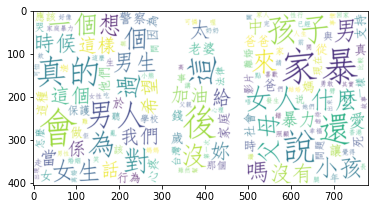

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
china = np.array(Image.open('../figures/MASK.png'))
wc = WordCloud(mask=china,background_color = "white",max_words = 300,font_path='../data/simfang.ttf',min_font_size = 15,max_font_size = 100,width = 200,height = 600)
wc.generate_from_frequencies(word_counts)
wc.to_file("WeiboText_Nuclear.png")
plt.figure()
plt.imshow(wc, interpolation="bilinear")
